In [4]:
import chromadb
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceEmbeddings
from langchain.schema import Document
import json
import os

In [57]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

OPENAI_API_KEY  = os.getenv('OPENAI_API_KEY')

# **RAG Delition Code if necessary to Fresh Start**

*Step 1: Release the database with the following code*

In [75]:
vectorstore = None  # Release the vector database
import gc
gc.collect()

1808

*Step 2: Restart the Kernel associated to the use of the Vectorstore database*

*Step 3: Delete the vectorstore by running the following code*

In [76]:
import os
import shutil

VECTORSTORE_PATH = r"C:\chromadb\landmarks_db"  # Update to the actual path

# Delete the existing database folder
if os.path.exists(VECTORSTORE_PATH):
    shutil.rmtree(VECTORSTORE_PATH)
    print("Previous RAG deleted successfully.")
else:
    print("No existing RAG found. Proceeding with a fresh build.")

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\chromadb\\landmarks_db\\9812a419-54c4-422b-8e21-a2a79ebc8ada\\data_level0.bin'

# **Step 1: Analyze Document Lengths & Metadata Completeness**

In [2]:
import os
import json
import numpy as np

# Define the path to final cleaned landmark data
cleaned_data_path = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\landmarks_cleaning\10Feb25_final_step02_links_clean"

# Collect document statistics
lengths = []
geo_metadata_missing = 0
total_files = 0

for file in os.listdir(cleaned_data_path):
    file_path = os.path.join(cleaned_data_path, file)

    with open(file_path, "r", encoding="utf-8") as f:
        landmark_data = json.load(f)

    text_content = landmark_data.get("main_content", "")
    lengths.append(len(text_content.split()))  # Count words
    total_files += 1

    if not landmark_data.get("geo_metadata"):
        geo_metadata_missing += 1

# Compute statistics
avg_length = np.mean(lengths)
max_length = np.max(lengths)
min_length = np.min(lengths)
std_dev = np.std(lengths)

print(f"Total landmarks processed: {total_files}")
print(f"Average document length: {avg_length:.2f} words")
print(f"Max length: {max_length} words | Min length: {min_length} words")
print(f"Standard deviation of lengths: {std_dev:.2f}")
print(f"Landmarks missing geo_metadata: {geo_metadata_missing} ({geo_metadata_missing / total_files:.2%})")

Total landmarks processed: 574
Average document length: 768.64 words
Max length: 14949 words | Min length: 41 words
Standard deviation of lengths: 1438.23
Landmarks missing geo_metadata: 0 (0.00%)


# **Step 2: Data Chunking, embedding and into DB**

In [ ]:
#!pip install langchain_openai

In [6]:
import os
import json
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [8]:
# Define the paths
cleaned_data_path = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\landmarks_cleaning\10Feb25_final_step02_links_clean"
vectorstore_path = r"C:\\chromadb\\landmarks_db"

# Initialize OpenAI embeddings
embeddings = OpenAIEmbeddings()

# Initialize text splitter
chunk_size = 1024
chunk_overlap = 0
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# Prepare documents for indexing
documents = []
for file in os.listdir(cleaned_data_path):
    file_path = os.path.join(cleaned_data_path, file)
    with open(file_path, "r", encoding="utf-8") as f:
        landmark_data = json.load(f)

    # Extract and normalize metadata
    geo_metadata = landmark_data.get("geo_metadata", {}) or {}
    title = geo_metadata.get("title", "Unknown Title")
    coordinates = geo_metadata.get("coordinates", [None, None])
    categories = ", ".join(landmark_data.get("categories", []))  # Convert list to string
    relevant_links = ", ".join(landmark_data.get("relevant_links", []))  # Convert list to string

    main_content = landmark_data.get("main_content", "")

    # Convert coordinates into a string format
    coordinates_str = f"{coordinates[0]}, {coordinates[1]}" if coordinates[0] is not None else "Unknown"

    # Split main content into chunks
    chunks = text_splitter.split_text(main_content)

    for chunk in chunks:
        document = {
            "content": chunk,
            "metadata": {
                "title": title,
                "coordinates": coordinates_str,  # Coordinates as a string
                "categories": categories,  # Converted list to string
                "relevant_links": relevant_links  # Converted list to string
            }
        }
        documents.append(document)

# Initialize ChromaDB
if not os.path.exists(vectorstore_path):
    os.makedirs(vectorstore_path)

vectorstore = Chroma(persist_directory=vectorstore_path, embedding_function=embeddings)

# Add documents to the vector database
for doc in documents:
    vectorstore.add_texts(texts=[doc["content"]], metadatas=[doc["metadata"]])

print("✅ RAG setup for landmarks completed. Vector database is ready.")

✅ RAG setup for landmarks completed. Vector database is ready.


# **New Approach for RAG System Creation**

# **This approach does not work**

import os
import json
import chromadb
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Define paths
DATA_PATH = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\landmarks_cleaning\10Feb25_final_step02_links_clean"
VECTORSTORE_PATH = r"C:\chromadb\landmarks_db"

# Initialize embeddings and vectorstore
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=VECTORSTORE_PATH, embedding_function=embeddings)

# Initialize chunking strategy
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

# Process all .txt files and add to vectorstore
for file_name in os.listdir(DATA_PATH):
    if file_name.endswith(".txt"):
        file_path = os.path.join(DATA_PATH, file_name)

        # Read JSON metadata file
        json_file_path = file_path.replace(".txt", ".json")  # Metadata should be in a .json file
        if not os.path.exists(json_file_path):
            print(f"Metadata file missing for {file_name}. Skipping...")
            continue

        with open(json_file_path, "r", encoding="utf-8") as meta_file:
            metadata = json.load(meta_file)

        # Extract metadata values
        main_content = metadata.get("main_content", "")  # Corrected content retrieval
        geo_metadata = metadata.get("geo_metadata", {}) or {}  # Ensure it's a dictionary
        title = geo_metadata.get("title", "Unknown Title")
        coordinates = geo_metadata.get("coordinates", [None, None])  # Ensure it's always a list
        categories = ", ".join(metadata.get("categories", []))  # Convert list to string
        relevant_links = ", ".join(metadata.get("relevant_links", []))  # Convert list to string

        # Chunk text for better retrieval
        chunks = text_splitter.split_text(main_content)

        for chunk in chunks:
            vectorstore.add_texts(
                texts=[chunk],
                metadatas=[{
                    "title": title,
                    "content": chunk,
                    "coordinates": f"{coordinates[0]}, {coordinates[1]}",
                    "categories": categories,
                    "relevant_links": relevant_links
                }]
            )

print("Landmark RAG successfully rebuilt with structured metadata & optimized chunking!")

**Step No. 1: Metadata Reading and Extraction**

In [15]:
import json
import os
from langchain.schema import Document

DATA_PATH = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\landmarks_cleaning\11Feb25_final_step03_chars_title_clean"

def process_txt_file(filepath):
    """ Extract metadata and content from a .txt file """
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.loads(f.read())  # Assuming JSON structure inside .txt

    # Extract content
    content = data.get("main_content", "")

    # Extract metadata
    geo_metadata = data.get("geo_metadata", {}) or {}
    title = geo_metadata.get("title", "Unknown Title")
    coordinates = geo_metadata.get("coordinates", [None, None])

    # Convert coordinates to a string
    coordinates_str = f"{coordinates[0]}, {coordinates[1]}" if all(coordinates) else "Unknown"

    # Extract categories
    categories = ", ".join(data.get("categories", []))  

    # Extract relevant links
    relevant_links = ", ".join(data.get("relevant_links", []))  

    return Document(
        page_content=content,
        metadata={
            "title": title,
            "coordinates": coordinates_str,
            "categories": categories,
            "relevant_links": relevant_links
        }
    )

# Process all .txt files
documents = []
for filename in os.listdir(DATA_PATH):
    if filename.endswith(".txt"):
        filepath = os.path.join(DATA_PATH, filename)
        doc = process_txt_file(filepath)
        documents.append(doc)

# Check some processed documents
print("Sample Processed Docs:", documents[:3])

Sample Processed Docs: [Document(metadata={'title': 'Academia del Perpetuo Socorro', 'coordinates': '18.45444, -66.08472', 'categories': 'Religion', 'relevant_links': 'https://en.wikipedia.org/w/index.php?title=Academia_del_Perpetuo_Socorro&oldid=1225685073, https://en.wikipedia.org/wiki/academia_del_perpetuo_socorro'}, page_content='Contents\nAcademia del Perpetuo Socorro\nMrs. Jeannette Sánchez (1-6)\\n\nAcademia del Perpetuo Socorro (English: "Academy of Our Lady of Perpetual Help") was founded in 1921 as a Catholic parochial school of the Perpetuo Socorro Parish at the Archdiocese of San Juan, Puerto Rico . The school is located in Miramar in Puerto Rico \\\'s capital city of San Juan . Students, teachers and alumni commonly refer to their school as Perpetuo.  \\n\nMission\nThe goal of the  Academia del Perpetuo Socorro is the complete development of the student - spiritually, mentally, morally, socially, culturally, and physically in order to live a full life and to prepare for hi

In [16]:
import json

# Define the output file path
output_file = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\pre-chunk clean data\landmarks_step1_docs_ext.json"

# Convert Document objects to a serializable format
serializable_docs = [
    {
        "metadata": doc.metadata,
        "page_content": doc.page_content
    }
    for doc in documents
]

# Save to JSON file
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(serializable_docs, f, indent=4, ensure_ascii=False)

print(f"Successfully saved {len(documents)} documents to {output_file}")

Successfully saved 574 documents to C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\pre-chunk clean data\landmarks_step1_docs_ext.json


In [19]:
for doc in documents:
    if "Cerro" in doc.metadata["title"]:
        print(f"Title: {doc.metadata['title']}\nCategories: {doc.metadata['categories']}\n")

Title: Cerro De Punta
Categories: Soft Adventure, Wildlife, Luxury & Resorts, Outdoor, Family-Friendly

Title: Cerro Las Tetas
Categories: Outdoor, Soft Adventure, Family-Friendly

Title: Cerro Maravilla
Categories: Culture

Title: Cerro Morales (utuado, Puerto Rico)
Categories: 

Title: Cerro Rosa
Categories: 



**Step No. 1a: Updating Documents**

In [37]:
from collections import defaultdict

processed_docs = documents.copy()  # Avoid modifying the original list

# Function to update categories properly
def update_landmark_categories(processed_docs, missing_landmarks, educational_landmarks):
    """
    Updates missing landmark categories by assigning proper default categories.
    Appends 'Educational Institution' to specific landmarks.

    Args:
        processed_docs (list): List of processed document dictionaries.
        missing_landmarks (dict): Dictionary with landmark titles as keys and default categories as values.
        educational_landmarks (list): List of landmarks that should include 'Educational Institution'.

    Returns:
        list: Updated processed documents.
    """
    updated_docs = []
    processed_docs = documents.copy()  # Avoid modifying the original list

    for doc in processed_docs:
        title = doc.metadata.get("title", "").strip()
        categories = set(doc.metadata.get("categories", "").split(", "))

        # Assign missing categories
        if title in missing_landmarks:
            categories.update(missing_landmarks[title])  # Add suggested categories
        
        # Append 'Educational Institution' where necessary
        if title in educational_landmarks:
            categories.add("Educational Institution")
        
        # Ensure unique categories and update document metadata
        doc.metadata["categories"] = ", ".join(sorted(filter(None, categories)))  # Sort for consistency
        updated_docs.append(doc)
    
    return updated_docs

# Dictionary of landmarks with missing categories and their proposed categories
missing_landmarks = {
    "Braulio Castillo": ["Culture"],
    "Carraízo Dam": ["Outdoor"],
    "Casa Franceschi Antongiorgi": ["Culture", "Family-Friendly"],
    "Faro del Castillo San Felipe del Morro": ["Culture", "Outdoor"],
    "Cementerio Civil de Ponce": ["Religion", "Culture"],
    "Cerro Morales (utuado, Puerto Rico)": ["Outdoor", "Adventure"],
    "Cerro Rosa": ["Outdoor", "Adventure"],
    "Coliseo Manuel Iguina": ["Sports", "Culture"],
    "Dos Bocas Lake": ["Outdoor", "Water Activities"],
    "Edificio Comunidad De Orgullo Gay De Puerto Rico": ["Culture", "LGBTQ+"],
    "Edificio Del Valle": ["Culture", "Architecture"],
    "Edificio Oliver": ["Culture", "Architecture"],
    "Edificio Victory Garden": ["Culture", "Architecture"],
    "El Gigante Dormido": ["Outdoor", "Adventure"],
    "El Monumento De La Recordación": ["Culture", "History"],
    "Escuela Brambaugh": ["Culture", "History"],
    "Estadio Country Club": ["Sports", "Culture"],
    "Cardona Island Light": ["Culture", "Outdoor"],
    "Filardi House": ["Culture", "Architecture"],
    "Fuerte De La Concepción": ["Culture", "History"],
    "Guánica Light": ["Culture", "Outdoor"],
    "Gómez Residence": ["Culture", "Architecture"],
    "Hacienda Santa Rita": ["Culture", "History"],
    "Hacienda San Francisco": ["Culture", "History"],
    "House At 659 Concordia Street": ["Culture", "Architecture"],
    "House At 659 La Paz Street": ["Culture", "Architecture"],
    "House At 663 La Paz Street": ["Culture", "Architecture"],
    "Lago Dos Bocas": ["Outdoor", "Water Activities"],
    "Las Cabañas Bridge": ["Culture", "Architecture"],
    "La Giralda (San Juan, Puerto Rico)": ["Culture", "Architecture"],
    "La Liendre Bridge": ["Culture", "Architecture"],
    "Logia Masónica Hijos De La Luz": ["Culture", "History"],
    "Los Tres Picachos": ["Outdoor", "Adventure"],
    "Los Túneles Subterráneos De San Germán": ["Culture", "History"],
    "Loíza Lake": ["Outdoor", "Water Activities"],
    "Luis A. Ferré United States Courthouse And Post Office Building": ["Culture", "Government"],
    "Mario Morales Coliseum": ["Sports", "Culture"],
    "Monte Jayuya": ["Outdoor", "Adventure"],
    "Monumento al Jíbaro Puertorriqueño": ["Culture", "History"],
    "Monumento a los héroes de El Polvorín (obelisk)": ["Culture", "History"],
    "Parque De Bombas Maximiliano Merced": ["Culture", "History"],
    "Paseo Víctor Rojas": ["Culture", "Family-Friendly"],
    "Puente Blanco": ["Culture", "Architecture"],
    "Puerto Del Rey Marina": ["Outdoor", "Water Activities"],
    "Roberto Clemente Stadium": ["Sports", "Culture"],
    "Rum Planetarium": ["Culture", "Science", "Educational Institution"],
    "Sabana Grande Masonic Cemetery": ["Religion", "Culture"],
    "Teodoro Moscoso Bridge": ["Culture", "Infrastructure"],
    "U.s. Post Office And Courthouse (mayagüez, Puerto Rico)": ["Culture", "Government"],
    "University Of Puerto Rico At Cayey": ["Educational Institution"]
}

# List of landmarks that should include "Educational Institution"
educational_landmarks = [
    "University Of Puerto Rico, Río Piedras Campus",
    "University Of Puerto Rico School Of Medicine",
    "University Of Puerto Rico, Medical Sciences Campus",
    "University Of Puerto Rico At Mayagüez",
    "Center For Advanced Studies On Puerto Rico And The Caribbean",
    "Universidad Del Sagrado Corazón",
    "Interamerican University Of Puerto Rico At Ponce",
    "Interamerican University Of Puerto Rico",
    "University Of Puerto Rico At Humacao",
    "University Of Puerto Rico At Ponce",
    "University Gardens High School",
    "University High School (San Juan)",
    "Polytechnic University Of Puerto Rico",
    "School Of Tropical Medicine (puerto Rico)",
    "Mizpa Pentecostal University",
    "Pontificia Universidad Católica de Puerto Rico",
    "Ponce School Of Medicine",
    "Escuela De Artes Plásticas Y Diseño De Puerto Rico",
    "Academia Interamericana Metro",
    "Academia del Perpetuo Socorro",
    "Escuela Brambaugh",
    "Conservatory Of Music Of Puerto Rico",
    "Saint John's School (San Juan)",
    "Arecibo Observatory",
    "Albizu University",
    "Academia San Jorge",
    "Academia Maria Reina",
    "Ana G. Méndez University",
    "Colegio San Conrado",
    "Ponce High School",
    "Central High School (san Juan, Puerto Rico)",
    "Colegio Ponceño",
    "Biblioteca Carnegie",
    "Albergue Olímpico"
]

# Apply the updates
updated_docs = update_landmark_categories(processed_docs, missing_landmarks, educational_landmarks)

# Display some sample results
for doc in updated_docs[:5]:  # Show first 5 updated docs
    print(f"Title: {doc.metadata['title']}\nCategories: {doc.metadata['categories']}\n")

Title: Academia del Perpetuo Socorro
Categories: Educational Institution, Religion

Title: Academia Interamericana Metro
Categories: Educational Institution, Religion

Title: Academia Maria Reina
Categories: Culture, Educational Institution, Food

Title: Academia San Jorge
Categories: Culture, Educational Institution, Religion

Title: Adjuntas Barrio-pueblo
Categories: Beach, Culture, Festivals & Events, Outdoor, Religion



In [22]:
print("Sample Processed Docs:", updated_docs[:3])

Sample Processed Docs: [Document(metadata={'title': 'Academia del Perpetuo Socorro', 'coordinates': '18.45444, -66.08472', 'categories': 'Educational Institution, Religion', 'relevant_links': 'https://en.wikipedia.org/w/index.php?title=Academia_del_Perpetuo_Socorro&oldid=1225685073, https://en.wikipedia.org/wiki/academia_del_perpetuo_socorro'}, page_content='Contents\nAcademia del Perpetuo Socorro\nMrs. Jeannette Sánchez (1-6)\\n\nAcademia del Perpetuo Socorro (English: "Academy of Our Lady of Perpetual Help") was founded in 1921 as a Catholic parochial school of the Perpetuo Socorro Parish at the Archdiocese of San Juan, Puerto Rico . The school is located in Miramar in Puerto Rico \\\'s capital city of San Juan . Students, teachers and alumni commonly refer to their school as Perpetuo.  \\n\nMission\nThe goal of the  Academia del Perpetuo Socorro is the complete development of the student - spiritually, mentally, morally, socially, culturally, and physically in order to live a full l

In [46]:
for doc in updated_docs:
    if "University" in doc.metadata["title"]:
        print(f"Title: {doc.metadata['title']}\nCategories: {doc.metadata['categories']}\n")

Title: Albizu University
Categories: Culture, Educational Institution

Title: Ana G. Méndez University
Categories: Culture, Educational Institution, Shopping

Title: Interamerican University Of Puerto Rico
Categories: Culture, Educational Institution, Outdoor, Religion

Title: Interamerican University Of Puerto Rico At Ponce
Categories: Culture, Educational Institution

Title: Mizpa Pentecostal University
Categories: Culture, Educational Institution, Religion

Title: Polytechnic University Of Puerto Rico
Categories: Culture, Educational Institution

Title: University Gardens High School
Categories: Culture, Educational Institution

Title: University High School (San Juan)
Categories: Culture, Educational Institution

Title: University Of Puerto Rico, Medical Sciences Campus
Categories: Culture, Educational Institution

Title: University Of Puerto Rico, Río Piedras Campus
Categories: Culture, Educational Institution, Festivals & Events, Nightlife, Outdoor

Title: University Of Puerto Ri

In [47]:
for doc in updated_docs:
    if "Coliseo" in doc.metadata["title"]:
        print(f"Title: {doc.metadata['title']}\nCategories: {doc.metadata['categories']}\n")

Title: Coliseo Manuel Iguina
Categories: Culture, Sports

Title: Coliseo Rubén Rodríguez
Categories: Culture, Festivals & Events



In [49]:
for doc in updated_docs:
    if "Lago" in doc.metadata["title"]:
        print(f"Title: {doc.metadata['title']}\nCategories: {doc.metadata['categories']}\n")

Title: Condado Lagoon
Categories: Beach, Luxury & Resorts

Title: Joyuda Lagoon
Categories: Beach

Title: Lago Dos Bocas
Categories: Outdoor, Water Activities

Title: Tortuguero Lagoon
Categories: Beach, Outdoor, Wildlife



In [50]:
import json

# Define the output file path
output_file = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\pre-chunk clean data\landmarks_step1a_updated_cat.json"

# Convert Document objects to a serializable format
serializable_docs = [
    {
        "metadata": doc.metadata,
        "page_content": doc.page_content
    }
    for doc in updated_docs
]

# Save to JSON file
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(serializable_docs, f, indent=4, ensure_ascii=False)

print(f"Successfully saved {len(updated_docs)} documents to {output_file}")

Successfully saved 574 documents to C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\pre-chunk clean data\landmarks_step1a_updated_cat.json


In [3]:
import json
from langchain.schema import Document

# Define the output file path
output_file = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\pre-chunk clean data\landmarks_updated_11feb25.json"

# Load from JSON file
with open(output_file, "r", encoding="utf-8") as f:
    loaded_docs = json.load(f)

# Convert back to Document objects
restored_docs = [
    Document(metadata=doc["metadata"], page_content=doc["page_content"])
    for doc in loaded_docs
]

print(f"Successfully loaded {len(restored_docs)} documents from {output_file}")

updated_docs=restored_docs.copy()

Successfully loaded 574 documents from C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\pre-chunk clean data\landmarks_updated_11feb25.json


**Step No. 2: Chunking Documents**

In [51]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Adaptive chunking strategy
SMALL_DOC_THRESHOLD = 500
MEDIUM_DOC_THRESHOLD = 2000

# Define chunking parameters dynamically
def get_chunk_parameters(doc_length):
    if doc_length <= SMALL_DOC_THRESHOLD:
        return None  # No chunking needed
    elif doc_length <= MEDIUM_DOC_THRESHOLD:
        return {"chunk_size": 500, "chunk_overlap": 50}
    else:
        return {"chunk_size": 1000, "chunk_overlap": 100}

chunked_documents = []

processed_docs = updated_docs.copy()  # Assuming we have processed the updated_docs from previous step

for doc in processed_docs:
    title = doc.metadata.get("title", "Unknown Title")
    coordinates = doc.metadata.get("coordinates", "Unknown")
    categories = doc.metadata.get("categories", "Unknown")
    relevant_links = doc.metadata.get("relevant_links", "")

    doc_length = len(doc.page_content.split())

    chunk_params = get_chunk_parameters(doc_length)
    if chunk_params is None:
        # Small docs, no chunking, add as-is
        chunked_documents.append({
            "content": doc.page_content,
            "metadata": {
                "title": title,
                "coordinates": coordinates,
                "categories": categories,
                "relevant_links": relevant_links
            }
        })
    else:
        # Apply chunking
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_params["chunk_size"],
            chunk_overlap=chunk_params["chunk_overlap"]
        )
        chunks = text_splitter.split_text(doc.page_content)

        for chunk in chunks:
            chunked_documents.append({
                "content": chunk,
                "metadata": {
                    "title": title,
                    "coordinates": coordinates,
                    "categories": categories,
                    "relevant_links": relevant_links
                }
            })

print(f"Total chunks created: {len(chunked_documents)}")

Total chunks created: 5088


**Step No. 3: Qucik Chunks Verification**

In [52]:
# Check first 5 chunks for verification
for i, chunk in enumerate(chunked_documents[:5]):
    print(f"🔹 Chunk {i+1}: {len(chunk['content'].split())} words | Title: {chunk['metadata']['title']}")
    print(chunk['content'][:300])  # Preview first 300 chars
    print("-" * 80)

🔹 Chunk 1: 325 words | Title: Academia del Perpetuo Socorro
Contents
Academia del Perpetuo Socorro
Mrs. Jeannette Sánchez (1-6)\n
Academia del Perpetuo Socorro (English: "Academy of Our Lady of Perpetual Help") was founded in 1921 as a Catholic parochial school of the Perpetuo Socorro Parish at the Archdiocese of San Juan, Puerto Rico . The school is located
--------------------------------------------------------------------------------
🔹 Chunk 2: 164 words | Title: Academia Interamericana Metro
Contents
Academia Interamericana Metro
The Academia Interamericana Metro (before Academia del Sagrado Corazón ) was founded in 1928 as a private and religious school in Santurce , Puerto Rico by Inter American University of Puerto Rico - Metro Cumpus.  The school provides elementary and high school 
--------------------------------------------------------------------------------
🔹 Chunk 3: 462 words | Title: Academia Maria Reina
Contents
Academia Maria Reina
Academia Maria Reina is a Catholic 

**Step No. 4: Categories Distribution Verification**

In [53]:
# Check categories distribution
from collections import Counter
category_counts = Counter([doc['metadata']['categories'] for doc in chunked_documents])
print(category_counts)

Counter({'Culture': 251, 'Culture, Religion': 202, 'Beach, Culture, Festivals & Events, Food, Luxury & Resorts, Nightlife, Outdoor, Religion, Wildlife': 130, 'Beach, Culture, Festivals & Events, Nightlife, Outdoor, Wellness & Relaxation': 129, 'Culture, Family-Friendly': 113, 'Culture, Family-Friendly, Festivals & Events, Food, Luxury & Resorts, Nightlife, Outdoor, Religion': 109, 'Culture, Family-Friendly, Outdoor': 103, 'Beach, Culture, Family-Friendly, Food, Luxury & Resorts, Outdoor, Religion, Shopping, Wildlife': 100, 'Culture, Educational Institution': 99, 'Beach, Culture': 99, 'Culture, Extreme Adventure, Family-Friendly, Festivals & Events, Food, Luxury & Resorts, Nightlife, Outdoor, Religion, Shopping, Wildlife': 96, 'Culture, Luxury & Resorts': 81, 'Culture, Outdoor': 76, 'Culture, Family-Friendly, Festivals & Events, Food, Luxury & Resorts, Nightlife, Outdoor': 75, 'Beach, Culture, Family-Friendly, Festivals & Events, Luxury & Resorts, Outdoor, Shopping': 71, 'Culture, Shopp

In [54]:
# Check which documents are missing categories
missing_categories = [doc['metadata']['title'] for doc in chunked_documents if not doc['metadata']['categories']]
print("Landmarks Missing Categories:", len(missing_categories))
print(missing_categories)

Landmarks Missing Categories: 0
[]


In [56]:
import json

# Define the output file path
output_file = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\chunked data\landmarks_chunks_11feb25.json"

# Save chunked documents as JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(chunked_documents, f, indent=4, ensure_ascii=False)

print(f"Successfully saved {len(chunked_documents)} chunks to {output_file}")

Successfully saved 5088 chunks to C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\chunked data\landmarks_chunks_11feb25.json


In [59]:
print(f"Loaded {len(chunked_documents)} chunks")
print("Sample Chunk:", chunked_documents[0])

Loaded 5088 chunks
Sample Chunk: {'content': 'Contents\nAcademia del Perpetuo Socorro\nMrs. Jeannette Sánchez (1-6)\\n\nAcademia del Perpetuo Socorro (English: "Academy of Our Lady of Perpetual Help") was founded in 1921 as a Catholic parochial school of the Perpetuo Socorro Parish at the Archdiocese of San Juan, Puerto Rico . The school is located in Miramar in Puerto Rico \\\'s capital city of San Juan . Students, teachers and alumni commonly refer to their school as Perpetuo.  \\n\nMission\nThe goal of the  Academia del Perpetuo Socorro is the complete development of the student - spiritually, mentally, morally, socially, culturally, and physically in order to live a full life and to prepare for his/her final goal - union with God. To this end, the school works to create a Catholic academic community in which faith, knowledge, and recreation are shared in a spirit of freedom, love, and creativity. The school, however, does not emphasize religion over other subjects, accepts students

**Step No. 5: Creation of the Vectorstore with ChromaDB**

In [ ]:
#!pip install -U langchain langchain-community langchain-chroma chromadb

In [77]:
import os
import json
import chromadb
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.schema import Document

# Initialize the OpenAI embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")  # Adjust model if needed

# Define the ChromaDB storage path
chroma_db_path = r"C:\Users\larry\chromadb_store\landmarks_db"

# Initialize a persistent ChromaDB client
chroma_client = chromadb.PersistentClient(path=chroma_db_path)

# Convert chunked documents into LangChain Document objects
docs = [
    Document(
        page_content=chunk["content"],
        metadata=chunk["metadata"]
    ) 
    for chunk in chunked_documents
]

# Create and store the vector database with ChromaDB
vectorstore = Chroma.from_documents(
    documents=docs, 
    embedding=embedding_model, 
    persist_directory=chroma_db_path
)

print("ChromaDB Vectorstore successfully created and stored at:", chroma_db_path)

ChromaDB Vectorstore successfully created and stored at: C:\Users\larry\chromadb_store\landmarks_db


**Step No. 6: Perform a Retrieval Test**

In [78]:
# Load the stored vectorstore from ChromaDB
vectorstore = Chroma(
    persist_directory=chroma_db_path, 
    embedding_function=embedding_model
)

# Perform a test query
query = "historical landmarks in San Juan"
results = vectorstore.similarity_search(query, k=5)  # Retrieve top 5 most relevant results

# Display retrieved results
print("\n**Search Results:**\n")
for idx, doc in enumerate(results):
    print(f"Result {idx+1}:")
    print(f"Title: {doc.metadata.get('title', 'Unknown')}")
    print(f"Snippet: {doc.page_content[:300]}...")  # Display first 300 characters
    print("-" * 80)


**Search Results:**

Result 1:
Title: Letras de Ponce
Snippet: from Ponce.  The landmark is said to be "known to every Puerto Rican."  \n...
--------------------------------------------------------------------------------
Result 2:
Title: Old San Juan
Snippet: Historic designations
The San Juan National Historic Site  was established in 1949 to preserve historic fortifications in Old San Juan and the National Register of Historic Places listed it in 1966.  Both that site and La Fortaleza ( English : The Fortress ) were then declared a single World Heritag...
--------------------------------------------------------------------------------
Result 3:
Title: Paseo de la Princesa
Snippet: Other landmarks and attractions are the Americas Heritage Fountain , the San Justo y Pastor Bastion , the La Concepción Bastion , and a playground for children. The promenade also hosts an open air café and a restaurant that serves traditional Puerto Rican food called Princesa Gastrobar .  Piraguas ...
--

In [79]:
# Load the stored vectorstore from ChromaDB
vectorstore = Chroma(
    persist_directory=chroma_db_path, 
    embedding_function=embedding_model
)

# Perform a test query
query = "historical landmarks in San Juan"
results = vectorstore.similarity_search_with_score(query, k=5)

# Display retrieved results with similarity scores
print("\n**Search Results with Similarity Scores:**\n")
for idx, (doc, score) in enumerate(results):
    print(f"Result {idx+1}:")
    print(f"Title: {doc.metadata.get('title', 'Unknown')}")
    print(f"Similarity Score: {score:.4f}")  # Display similarity score
    print(f"Snippet: {doc.page_content[:300]}...")  # Show first 300 characters
    print("-" * 80)



**Search Results with Similarity Scores:**

Result 1:
Title: Letras de Ponce
Similarity Score: 0.2129
Snippet: from Ponce.  The landmark is said to be "known to every Puerto Rican."  \n...
--------------------------------------------------------------------------------
Result 2:
Title: Old San Juan
Similarity Score: 0.2556
Snippet: Historic designations
The San Juan National Historic Site  was established in 1949 to preserve historic fortifications in Old San Juan and the National Register of Historic Places listed it in 1966.  Both that site and La Fortaleza ( English : The Fortress ) were then declared a single World Heritag...
--------------------------------------------------------------------------------
Result 3:
Title: Paseo de la Princesa
Similarity Score: 0.2593
Snippet: Other landmarks and attractions are the Americas Heritage Fountain , the San Justo y Pastor Bastion , the La Concepción Bastion , and a playground for children. The promenade also hosts an open air café and a

In [80]:
# To verify if the embeddings are working correctly, we can embed a query and check the first few values of the embedding vector.
from langchain.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")

query = "historical landmarks in San Juan"
query_embedding = embedding_model.embed_query(query)

print(query_embedding[:5])  # Show first 5 values to verify

[-0.029638236794412798, -0.004587519045408049, 0.003929724504965821, -0.003231031165929953, -0.009611295667771934]


**Step No. 7: Inspecting the RAG Vector Database Structure and Content**

In [ ]:
#!pip install -U langchain-chroma

In [81]:
import chromadb
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import random

# Define the path to the vectorstore (RAG system)
VECTORSTORE_PATH = "C:\chromadb\landmarks_db"

# Initialize embeddings and vectorstore
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=VECTORSTORE_PATH, embedding_function=embeddings)

# Check the total number of indexed documents
num_docs = vectorstore._collection.count()
print(f"\nTotal Number of Documents in RAG: {num_docs}")

# Retrieve random sample documents to inspect content and metadata
sample_size = min(5, num_docs)  # Limit to 5 samples
random_indices = random.sample(range(num_docs), sample_size)
print("\n=== Random Document Samples ===")

for idx in random_indices:
    doc = vectorstore._collection.get(include=["metadatas", "documents"], ids=[str(idx)])
    
    if doc and "documents" in doc and len(doc["documents"]) > 0:
        doc_content = doc["documents"][0][:500]  # Show first 500 characters
        doc_metadata = doc["metadatas"][0] if "metadatas" in doc and len(doc["metadatas"]) > 0 else "No metadata"
        print(f"\n**Document {idx}**")
        print(f"Title: {doc_metadata.get('title', 'Unknown')}")
        print(f"Metadata: {doc_metadata}")
        print(f"Content Preview: {doc_content}...\n")
    else:
        print(f"No data found for document {idx}")

print("\nRAG Database Inspection Completed.")


Total Number of Documents in RAG: 5088

=== Random Document Samples ===
No data found for document 1002
No data found for document 3607
No data found for document 560
No data found for document 1304
No data found for document 3670

RAG Database Inspection Completed.


In [82]:
sample_docs = vectorstore.get(["1", "2", "3"])  # Retrieve first few stored docs
for doc in sample_docs:
    print(doc.metadata)
    print(doc.page_content[:200])  # Show first 200 characters

AttributeError: 'str' object has no attribute 'metadata'

In [66]:
sample_docs = vectorstore.get(["1", "10", "50"])  # Retrieve sample docs

for doc in sample_docs:
    print("Title:", doc.metadata.get("title", "Unknown"))
    print("Categories:", doc.metadata.get("categories", "Unknown"))
    print("Snippet:", doc.page_content[:300], "...")
    print("-" * 80)

AttributeError: 'str' object has no attribute 'metadata'

In [67]:
# Retrieve a few available documents
doc_sample = vectorstore._collection.get(include=["metadatas", "documents"], limit=5)  # Get first 5 docs

if doc_sample and "documents" in doc_sample:
    for i in range(len(doc_sample["documents"])):
        doc_content = doc_sample["documents"][i][:500]  # First 500 characters
        doc_metadata = doc_sample["metadatas"][i] if "metadatas" in doc_sample else "No metadata"
        
        print(f"\n**Document {i}**")
        print(f"Title: {doc_metadata.get('title', 'Unknown')}")
        print(f"Metadata: {doc_metadata}")
        print(f"Content Preview: {doc_content}...\n")
else:
    print("No documents retrieved from the collection.")


**Document 0**
Title: Academia del Perpetuo Socorro
Metadata: {'categories': 'Educational Institution, Religion', 'coordinates': '18.45444, -66.08472', 'relevant_links': 'https://en.wikipedia.org/w/index.php?title=Academia_del_Perpetuo_Socorro&oldid=1225685073, https://en.wikipedia.org/wiki/academia_del_perpetuo_socorro', 'title': 'Academia del Perpetuo Socorro'}
Content Preview: Contents
Academia del Perpetuo Socorro
Mrs. Jeannette Sánchez (1-6)\n
Academia del Perpetuo Socorro (English: "Academy of Our Lady of Perpetual Help") was founded in 1921 as a Catholic parochial school of the Perpetuo Socorro Parish at the Archdiocese of San Juan, Puerto Rico . The school is located in Miramar in Puerto Rico \'s capital city of San Juan . Students, teachers and alumni commonly refer to their school as Perpetuo.  \n
Mission
The goal of the  Academia del Perpetuo Socorro is the co...


**Document 1**
Title: Academia Interamericana Metro
Metadata: {'categories': 'Educational Institution, Religio

In [83]:
# Retrieve and inspect the first 5 documents stored in the database
sample_docs = vectorstore._collection.get(include=["documents", "metadatas"], limit=5)
print(sample_docs)

{'ids': ['ddc0eddf-0a85-4bb1-a8a3-2a392c587222', '68857fa8-2905-43b3-8690-671d76a9b8e1', '27897e93-9505-43e9-a9c4-2f0c1d0e4538', '6610138d-be5f-4ef9-b247-5adc6c6e80f6', 'f5bfd013-a0d5-4305-a1e4-6c8bea0802ec'], 'embeddings': None, 'documents': ['Contents\nAcademia del Perpetuo Socorro\nMrs. Jeannette Sánchez (1-6)\\n\nAcademia del Perpetuo Socorro (English: "Academy of Our Lady of Perpetual Help") was founded in 1921 as a Catholic parochial school of the Perpetuo Socorro Parish at the Archdiocese of San Juan, Puerto Rico . The school is located in Miramar in Puerto Rico \\\'s capital city of San Juan . Students, teachers and alumni commonly refer to their school as Perpetuo.  \\n\nMission\nThe goal of the  Academia del Perpetuo Socorro is the complete development of the student - spiritually, mentally, morally, socially, culturally, and physically in order to live a full life and to prepare for his/her final goal - union with God. To this end, the school works to create a Catholic acade

In [87]:
query = "Tell me about El Yunque National Forest."
docs = vectorstore.similarity_search(query, k=5)

for doc in docs:
    print(f"\nTitle: {doc.metadata.get('title', 'Unknown')}")
    print(f"Similarity Score: {doc.metadata.get('similarity', 'N/A')}")
    print(f"Content Preview: {doc.page_content[:300]}...\n")


Title: El Yunque National Forest
Similarity Score: N/A
Content Preview: Contents
El Yunque National Forest
El Yunque National Forest , formerly known as the Caribbean National Forest (or Bosque Nacional del Caribe ),   is a forest located in northeastern Puerto Rico . While there are both temperate and tropical rainforests in other states and territories, it is the only...


Title: El Yunque National Forest
Similarity Score: N/A
Content Preview: Recreation
In addition to being an important ecological forest reserve, El Yunque National Forest is one of the most popular tourist attractions in Puerto Rico,  both for locals and visitors, and it offers numerous recreational opportunities such as picnicking, birdwatching, and biking in designated...


Title: El Yunque National Forest
Similarity Score: N/A
Content Preview: History
\nThe area of the El Yunque National Forest has been notable since the pre-Columbian era. The forest today is home to several archaeological sites related to the i

In [70]:
import chromadb

# Load the vectorstore
VECTORSTORE_PATH = r"C:\chromadb\landmarks_db"
vectorstore = chromadb.PersistentClient(path=VECTORSTORE_PATH).get_or_create_collection(name="landmarks")

# Get all documents
all_documents = vectorstore.get(include=["documents", "metadatas"])

# Extract metadata
metadata_list = all_documents["metadatas"]

# 1️ Check total number of indexed documents
num_docs = len(metadata_list)
print(f"Total Number of Indexed Documents: {num_docs}")

# 2️ Check unique titles to detect duplicate entries
unique_titles = set(meta.get("title", "Unknown Title") for meta in metadata_list)
print(f"Unique Titles in RAG: {len(unique_titles)} (duplicates exist if this is lower than total docs)")

# 3️ Verify metadata completeness
missing_metadata = [meta for meta in metadata_list if not all(k in meta for k in ["title", "coordinates", "categories"])]
if missing_metadata:
    print(f"{len(missing_metadata)} documents are missing metadata fields.")

# 4️ Check category distribution
category_counts = {}
for meta in metadata_list:
    categories = meta.get("categories", "Unknown").split(", ")
    for category in categories:
        category_counts[category] = category_counts.get(category, 0) + 1

print("Category Distribution:")
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {category}: {count} documents")

# 5️ Identify documents without categories
no_category_docs = [meta["title"] for meta in metadata_list if meta.get("categories") in [None, "", "Unknown"]]
if no_category_docs:
    print(f"{len(no_category_docs)} documents are missing categories.")
    print("Sample missing category docs:", no_category_docs[:5])

# 6️ Check if coordinates exist for all landmarks
missing_coordinates = [meta["title"] for meta in metadata_list if meta.get("coordinates") in [None, "", "Unknown"]]
if missing_coordinates:
    print(f"{len(missing_coordinates)} documents are missing coordinates.")
    print("Sample missing coordinate docs:", missing_coordinates[:5])


Total Number of Indexed Documents: 0
Unique Titles in RAG: 0 (duplicates exist if this is lower than total docs)
Category Distribution:


In [71]:
import numpy as np

query_embedding = embedding_model.embed_query("historical landmarks in San Juan")
doc_embedding = vectorstore._collection.get(ids=["1"])["embeddings"][0]

similarity = np.dot(query_embedding, doc_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_embedding))

print(f"Cosine similarity between query and doc[1]: {similarity:.4f}")

AttributeError: 'Collection' object has no attribute '_collection'

In [73]:
print(f"First 5 docs before indexing: {docs[:5]}")

First 5 docs before indexing: [Document(id='674e4d75-9bac-4573-bfc4-fe1cc3be6e0e', metadata={'categories': 'Beach, Culture, Extreme Adventure, Family-Friendly, Food, Outdoor, Soft Adventure, Wildlife', 'coordinates': '18.317, -65.783', 'relevant_links': 'https://es.wikipedia.org/wiki/Bosque_nacional_El_Yunque, https://en.wikivoyage.org/wiki/El_Yunque_National_Forest, https://en.wikipedia.org/w/index.php?title=El_Yunque_National_Forest&oldid=1247942399, https://www.discoverpuertorico.com/list/top-places-to-see-puerto-rico#!grid~~~random~1, https://en.wikipedia.org/wiki/el_yunque_national_forest', 'title': 'El Yunque National Forest'}, page_content='Contents\nEl Yunque National Forest\nEl Yunque National Forest , formerly known as the Caribbean National Forest (or Bosque Nacional del Caribe ),   is a forest located in northeastern Puerto Rico . While there are both temperate and tropical rainforests in other states and territories, it is the only tropical rainforest in the United States 

In [74]:
sample_docs = vectorstore._collection.get(include=["documents", "metadatas"], limit=5)

AttributeError: 'Collection' object has no attribute '_collection'

In [84]:
print(f"Total documents in vectorstore: {vectorstore._collection.count()}")

Total documents in vectorstore: 5088


In [85]:
# Retrieve a sample of stored documents
sample_docs = vectorstore._collection.get(include=["documents", "metadatas"], limit=5)

# Check if documents exist
if "documents" in sample_docs and sample_docs["documents"]:
    for i in range(len(sample_docs["documents"])):
        doc_content = sample_docs["documents"][i][:500]  # First 500 characters
        doc_metadata = sample_docs["metadatas"][i] if "metadatas" in sample_docs else "No metadata"

        print(f"\n**Document {i}**")
        print(f"Title: {doc_metadata.get('title', 'Unknown')}")
        print(f"Metadata: {doc_metadata}")
        print(f"Content Preview: {doc_content}...\n")
else:
    print("No documents retrieved from the collection.")


**Document 0**
Title: Academia del Perpetuo Socorro
Metadata: {'categories': 'Educational Institution, Religion', 'coordinates': '18.45444, -66.08472', 'relevant_links': 'https://en.wikipedia.org/w/index.php?title=Academia_del_Perpetuo_Socorro&oldid=1225685073, https://en.wikipedia.org/wiki/academia_del_perpetuo_socorro', 'title': 'Academia del Perpetuo Socorro'}
Content Preview: Contents
Academia del Perpetuo Socorro
Mrs. Jeannette Sánchez (1-6)\n
Academia del Perpetuo Socorro (English: "Academy of Our Lady of Perpetual Help") was founded in 1921 as a Catholic parochial school of the Perpetuo Socorro Parish at the Archdiocese of San Juan, Puerto Rico . The school is located in Miramar in Puerto Rico \'s capital city of San Juan . Students, teachers and alumni commonly refer to their school as Perpetuo.  \n
Mission
The goal of the  Academia del Perpetuo Socorro is the co...


**Document 1**
Title: Academia Interamericana Metro
Metadata: {'categories': 'Educational Institution, Religio

In [86]:
import numpy as np

# Generate an embedding for a sample query
query_embedding = embedding_model.embed_query("historical landmarks in San Juan")

# Retrieve embeddings for a stored document
doc_embedding = vectorstore._collection.get(include=["embeddings"], limit=1)["embeddings"][0]

# Compute cosine similarity
similarity = np.dot(query_embedding, doc_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_embedding))

print(f"Cosine similarity between query and first document: {similarity:.4f}")

Cosine similarity between query and first document: 0.7663


# **Pre-RAG Verification Code (Full Implementation)**

In [ ]:
import chromadb
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Define the path to the vectorstore (RAG system)
VECTORSTORE_PATH = "/path/to/chromadb/landmarks_db"  # Update this with the actual path

# Initialize embeddings and vectorstore
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=VECTORSTORE_PATH, embedding_function=embeddings)

# Define test queries for RAG verification
test_queries = [
    "Where is El Yunque National Forest located?",
    "Tell me about Castillo San Felipe del Morro.",
    "What are the most famous beaches in Puerto Rico?",
    "Which landmarks should I visit in Old San Juan?",
    "What are the best hiking trails in Puerto Rico?"
]

# Initialize an empty list to store retrieval results
retrieval_results = []

# Function to check retrieval quality
def evaluate_retrieval(query):
    """Retrieves documents from the RAG system and logs similarity scores."""
    docs = vectorstore.similarity_search(query, k=3)  # Retrieve top 3 documents
    retrieved_chunks = []
    
    for doc in docs:
        chunk_data = {
            "query": query,
            "retrieved_text": doc.page_content[:300] + "...",  # Show only first 300 chars
            "source_title": doc.metadata.get("title", "Unknown"),
            "similarity_score": doc.metadata.get("similarity", "N/A")
        }
        retrieved_chunks.append(chunk_data)
    
    return retrieved_chunks

# Run retrieval tests on all queries
for query in test_queries:
    retrieval_results.extend(evaluate_retrieval(query))

# Convert results to DataFrame for better readability
retrieval_df = pd.DataFrame(retrieval_results)

# Display verification results
print("\n=== Pre-RAG Verification Results ===")
print(retrieval_df.to_string(index=False))

# Save results to a CSV file for further analysis
retrieval_df.to_csv("rag_verification_results.csv", index=False)

# **RAG - Landmarks: Retreival Performance Test and Metrics**

In [ ]:
#!pip install matplotlib

In [ ]:
#!pip install nltk

In [ ]:
#!pip install rouge

In [10]:
import os
import json
import time
import psutil
import chromadb
import matplotlib.pyplot as plt
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

c:\Users\larry\anaconda3\envs\travel2pr_ai\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\larry\anaconda3\envs\travel2pr_ai\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


RAG evaluation completed. Results saved to C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\RAG Tests\lm_test01\rag_evaluation_results.json


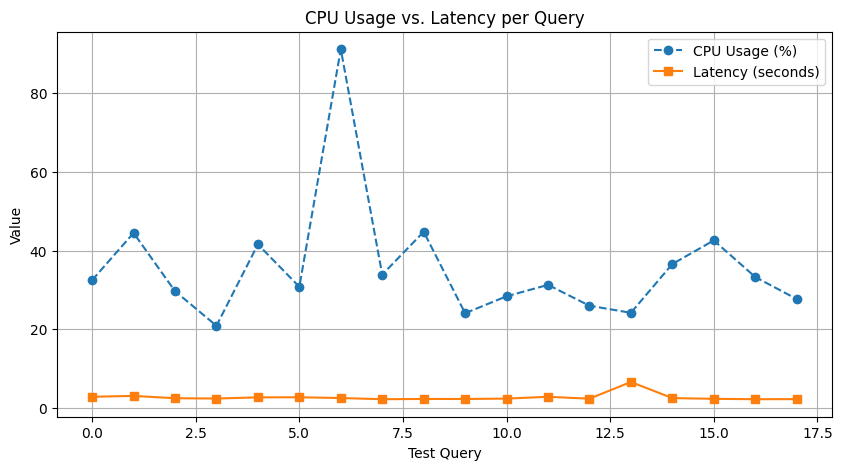

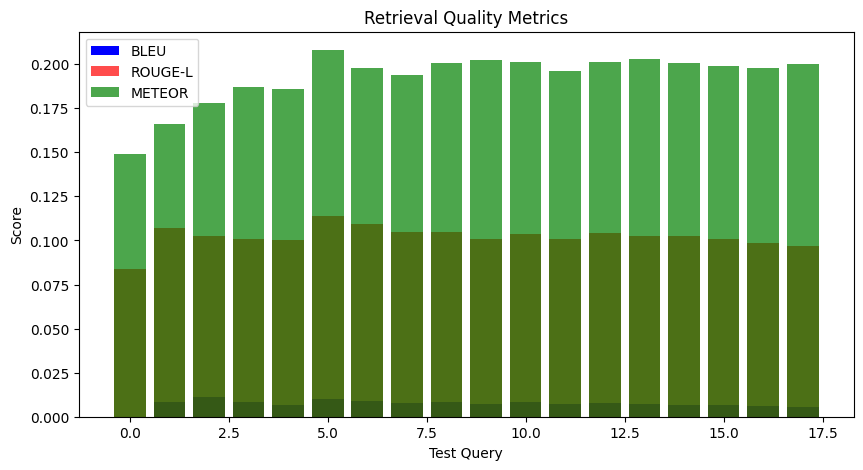

In [ ]:
# Set paths
VECTORSTORE_PATH = r"C:\chromadb\landmarks_db"
TEST_SET_PATH = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\RAG Tests\lm_test02\rag_test_queries.json"
RESULTS_OUTPUT_PATH = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\RAG Tests\lm_test02\rag_evaluation_results.json"

# Load embeddings & vectorstore
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=VECTORSTORE_PATH, embedding_function=embeddings)

# Load test queries
with open(TEST_SET_PATH, "r", encoding="utf-8") as f:
    test_queries = json.load(f)

# Initialize performance log
evaluation_results = []

def measure_cpu():
    """Returns CPU usage as a percentage."""
    return psutil.cpu_percent(interval=1)

def evaluate_retrieval(query):
    """Runs the query, retrieves documents, measures similarity, and evaluates the response."""
    start_time = time.time()
    cpu_before = measure_cpu()

    # Run retrieval
    docs = vectorstore.similarity_search(query, k=3)  # Using top-k = 3

    cpu_after = measure_cpu()
    latency = time.time() - start_time

    # Extract retrieved texts
    retrieved_texts = [doc.page_content for doc in docs]
    retrieved_titles = [doc.metadata.get("title", "Unknown") for doc in docs]

    return retrieved_texts, retrieved_titles, cpu_before, cpu_after, latency

# Initialize evaluation metrics
rouge = Rouge()
rouge_scores, meteor_scores, bleu_scores = [], [], []

# Run evaluation on all queries
for entry in test_queries:
    query = entry["query"]
    expected_answers = entry["expected_answers"]

    # Retrieve the text using the RAG retriever
    retrieved_texts, retrieved_titles, cpu_before, cpu_after, latency = evaluate_retrieval(query)

    # Tokenize the expected answers and retrieved texts for METEOR
    expected_tokens = [word_tokenize(answer) for answer in expected_answers]
    retrieved_tokens = word_tokenize(" ".join(retrieved_texts))

    # Calculate evaluation metrics
    rouge_score = rouge.get_scores(" ".join(retrieved_texts), " ".join(expected_answers))[0]["rouge-l"]["f"]
    meteor_score_value = meteor_score(expected_tokens, retrieved_tokens)
    bleu_score = sentence_bleu([answer.split() for answer in expected_answers], " ".join(retrieved_texts).split())

    rouge_scores.append(rouge_score)
    meteor_scores.append(meteor_score_value)
    bleu_scores.append(bleu_score)

    avg_rouge = sum(rouge_scores) / len(rouge_scores)
    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # Log results
    result_entry = {
        "query": query,
        "expected_answers": expected_answers,
        "retrieved_texts": retrieved_texts,
        "retrieved_titles": retrieved_titles,
        "retrieval_scores": {
            "ROUGE-L": avg_rouge,
            "METEOR": avg_meteor,
            "BLEU": avg_bleu
        },
        "cpu_usage": f"{cpu_before}% -> {cpu_after}%",
        "latency": f"{latency:.4f} seconds"
    }
    evaluation_results.append(result_entry)

# Save results
with open(RESULTS_OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(evaluation_results, f, indent=4, ensure_ascii=False)

print(f"RAG evaluation completed. Results saved to {RESULTS_OUTPUT_PATH}")

# Visualization (CPU vs. Latency)
cpu_usage_data = [float(entry["cpu_usage"].split("->")[1].strip()[:-1]) for entry in evaluation_results]
latency_data = [float(entry["latency"].split()[0]) for entry in evaluation_results]

plt.figure(figsize=(10, 5))
plt.plot(cpu_usage_data, label="CPU Usage (%)", marker="o", linestyle="--")
plt.plot(latency_data, label="Latency (seconds)", marker="s", linestyle="-")
plt.xlabel("Test Query")
plt.ylabel("Value")
plt.title("CPU Usage vs. Latency per Query")
plt.legend()
plt.grid(True)
plt.show()

# Visualization (Retrieval Scores)
bleu_scores = [entry["retrieval_scores"]["BLEU"] for entry in evaluation_results]
rouge_scores = [entry["retrieval_scores"]["ROUGE-L"] for entry in evaluation_results]
meteor_scores = [entry["retrieval_scores"]["METEOR"] for entry in evaluation_results]

plt.figure(figsize=(10, 5))
plt.bar(range(len(bleu_scores)), bleu_scores, color="blue", label="BLEU")
plt.bar(range(len(rouge_scores)), rouge_scores, color="red", label="ROUGE-L", alpha=0.7)
plt.bar(range(len(meteor_scores)), meteor_scores, color="green", label="METEOR", alpha=0.7)
plt.xlabel("Test Query")
plt.ylabel("Score")
plt.title("Retrieval Quality Metrics")
plt.legend()
plt.show()